# Import Dependencies

In [1]:
# Check system install
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # Should return True if GPU is detected

# General Imports
import numpy as np
import pandas as pd
import random
from tqdm import tqdm 
from torch.optim import Adam
import monai
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from concurrent.futures import ThreadPoolExecutor
import torch.nn.functional as F
from monai.losses import DiceLoss


# Class Imports
# Reload modules so classes are reloaded every time
import importlib
import image_mask_dataset
import model_evaluator

from image_mask_dataset import ImageMaskDataset
from model_evaluator import ModelEvaluator



# SAM
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from transformers import SamModel, SamProcessor, SamConfig



c:\Users\osmit\anaconda3\envs\pytorch-env\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


2.6.0+cu126
True


## Gather data for each split

In [31]:
importlib.reload(image_mask_dataset)
importlib.reload(model_evaluator)

# Initialize the processor
processor = SamProcessor.from_pretrained("facebook/sam-vit-large")

# Create dataset objects for each split
dataset_path = "Datasets/Dental project.v19i.coco-1"

test_dataset = ImageMaskDataset(dataset_path, "test", processor)
train_dataset = ImageMaskDataset(dataset_path, "train", processor)
valid_dataset = ImageMaskDataset(dataset_path, "valid", processor)



test_dataset[0]["pixel_values"].shape

# Test using a random image
# test_dataset.show_image_mask(random.randint(0,len(test_dataset)-1))
# train_dataset.show_image_mask(random.randint(0,len(train_dataset)-1))
# valid_dataset.show_image_mask(random.randint(0,len(valid_dataset)-1))



100%|██████████| 157/157 [00:00<00:00, 9662.03it/s]


(640, 640, 3)

# Base Model Evaluation

### Get image:

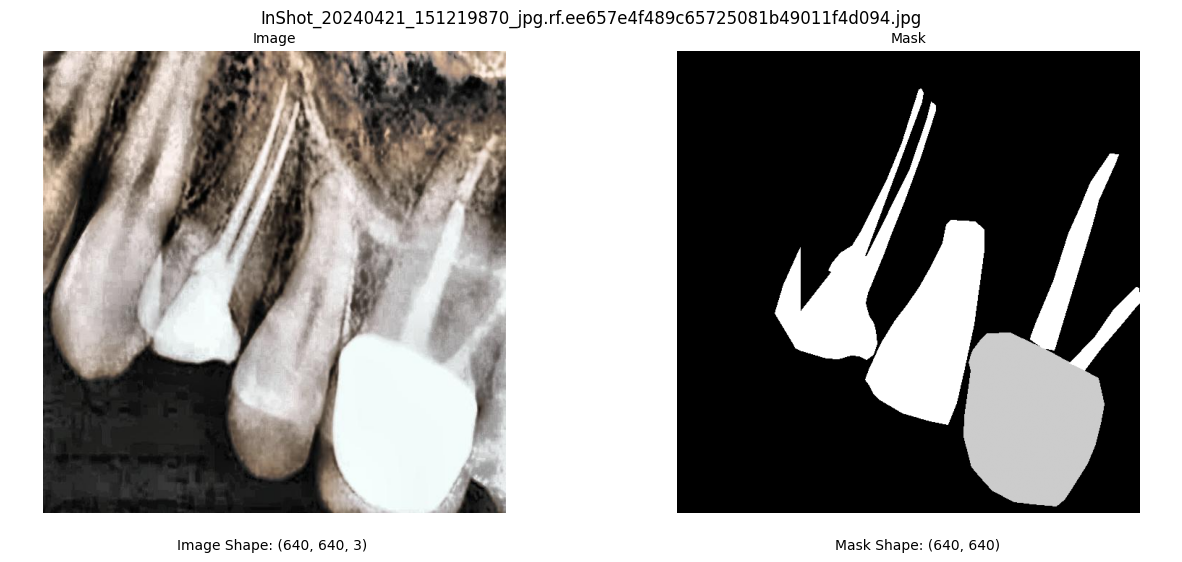

Loaded image shape: (640, 640, 3)


In [32]:
# Choose is pre-processing is applied (very different results)
test_dataset.return_as_sam  = False
train_dataset.return_as_sam = False
valid_dataset.return_as_sam = False


# Select random image
image_idx = random.randint(0, len(test_dataset)-1)

image_idx = 12 # delete this

# Show image and mask
test_dataset.show_image_mask(image_idx)

# Load an image (This works far better if you don'd convert to a tensor first)
image = test_dataset[image_idx]["pixel_values"]

print(f"Loaded image shape: {image.shape}")



## SAM Base Model Inference

### Initialise SAM Model

In [33]:
# Load the SAM model
sam_checkpoint = "Models/sam_vit_l_0b3195.pth" 
sam_model = sam_model_registry["vit_l"](checkpoint=sam_checkpoint)
sam_model = sam_model.to("cuda")


### SAM - Base model predictions (no grid):

In [34]:
# Initialize Automatic Mask Generator and generate mask
mask_generator = SamAutomaticMaskGenerator(sam_model)
masks = mask_generator.generate(image)


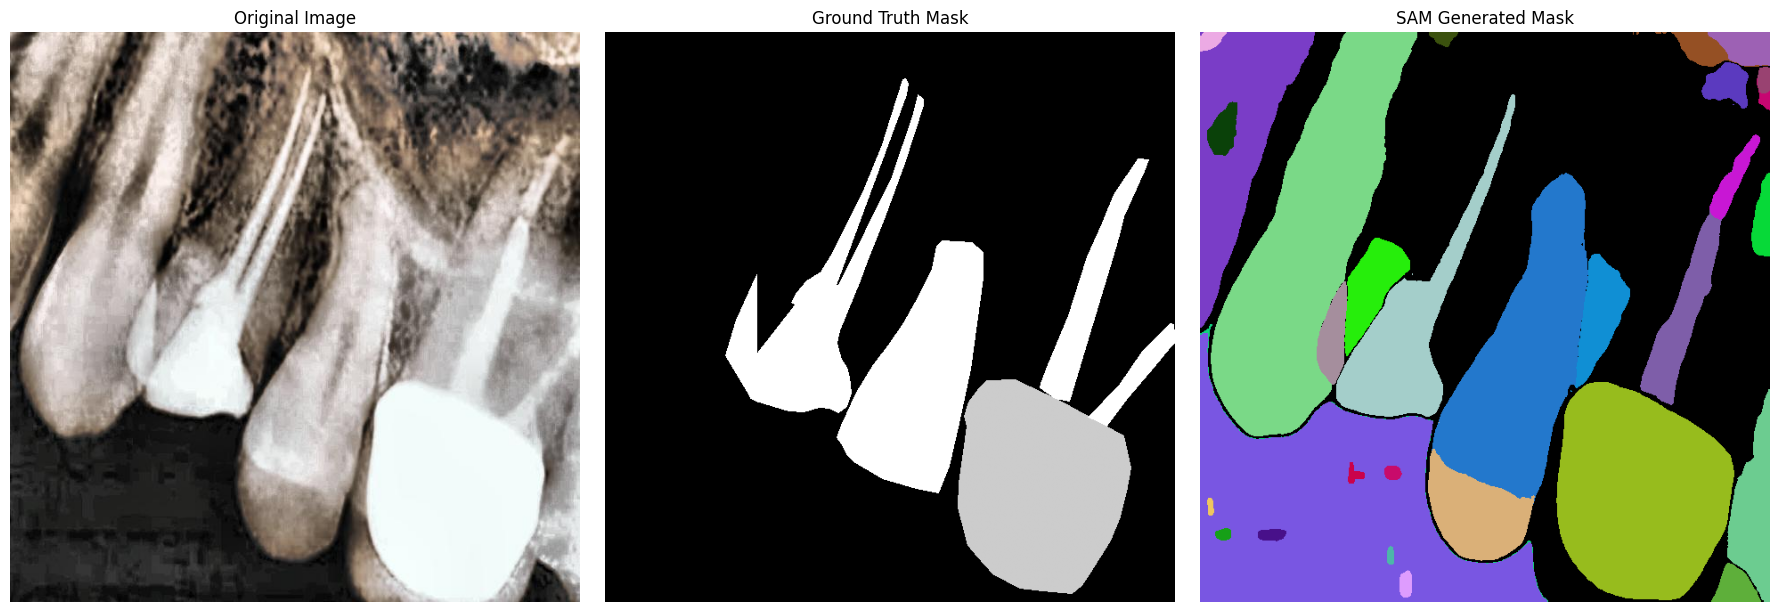

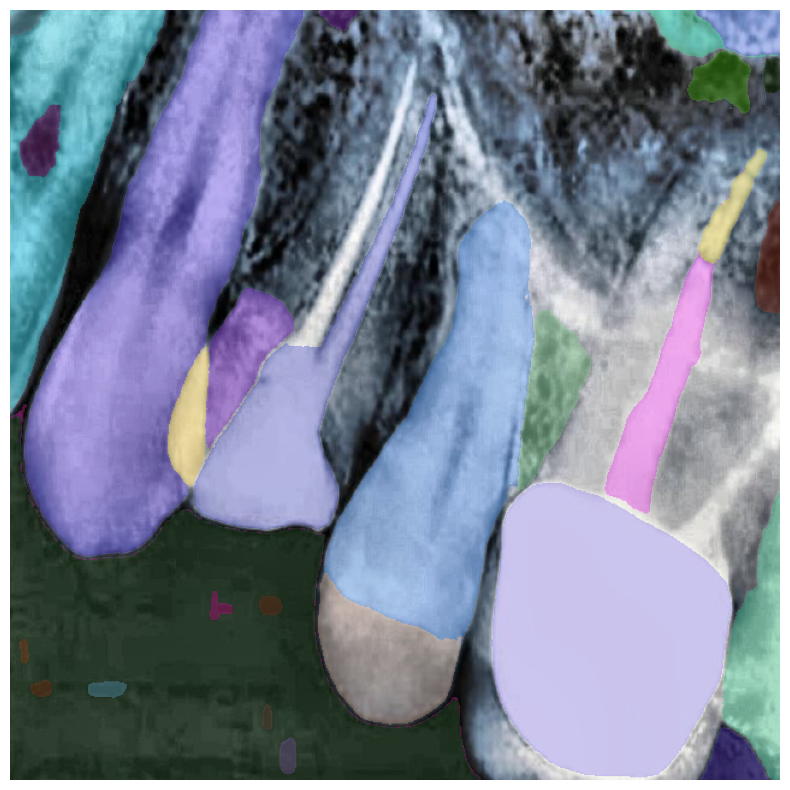

In [7]:
# Visualise Output
test_dataset.compare_image_masks(image_idx, masks)

test_dataset.show_anns(image_idx, masks)


### SAM - Base model predictions (grid of points):

In [8]:


# Create grid of points on image
height, width, _ = image.shape
num_points = 5 - 1 # 5*5 points

# Generate grid points
grid_points = []
for y in range(0, height + height // num_points, height // num_points):
    for x in range(0, width + width // num_points, width // num_points):
        grid_points.append([y, x])  # Each point is (x, y)

grid_points = np.array(grid_points)



# Initialize the SAM predictor
sam_predictor = SamPredictor(sam_model)

# Set the image once for the SAM predictor
sam_predictor.set_image(image)



# Function to generate mask for each point
def generate_mask_for_point(point):
    return sam_predictor.predict(point_coords=point[None, :], point_labels=np.array([1]))

# Use ThreadPoolExecutor to parallelize mask generation
with ThreadPoolExecutor() as executor:
    masks = list(executor.map(generate_mask_for_point, grid_points))

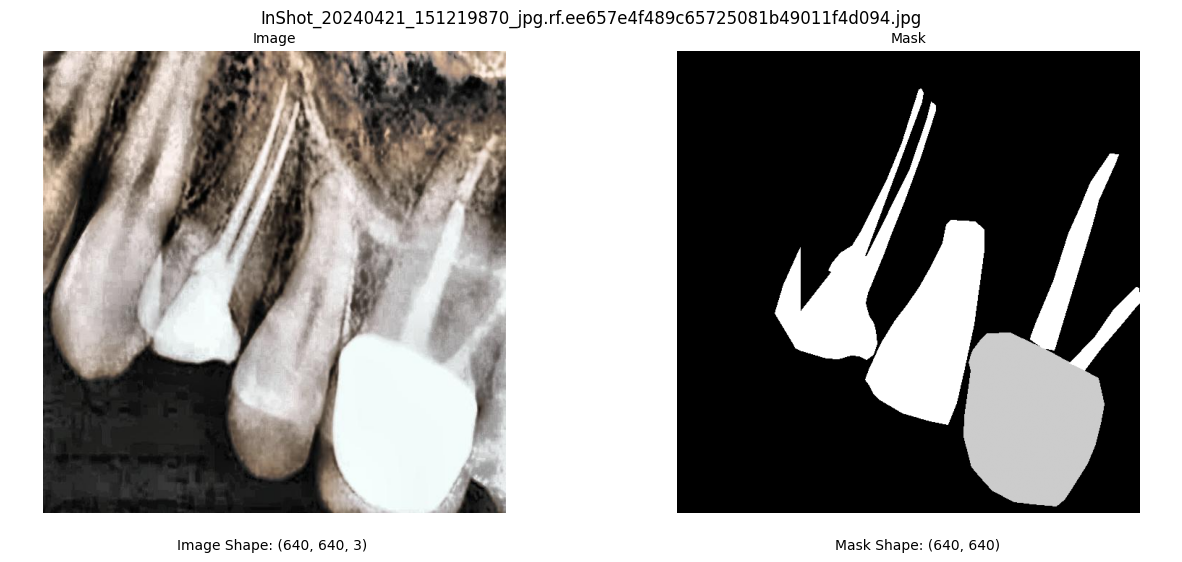

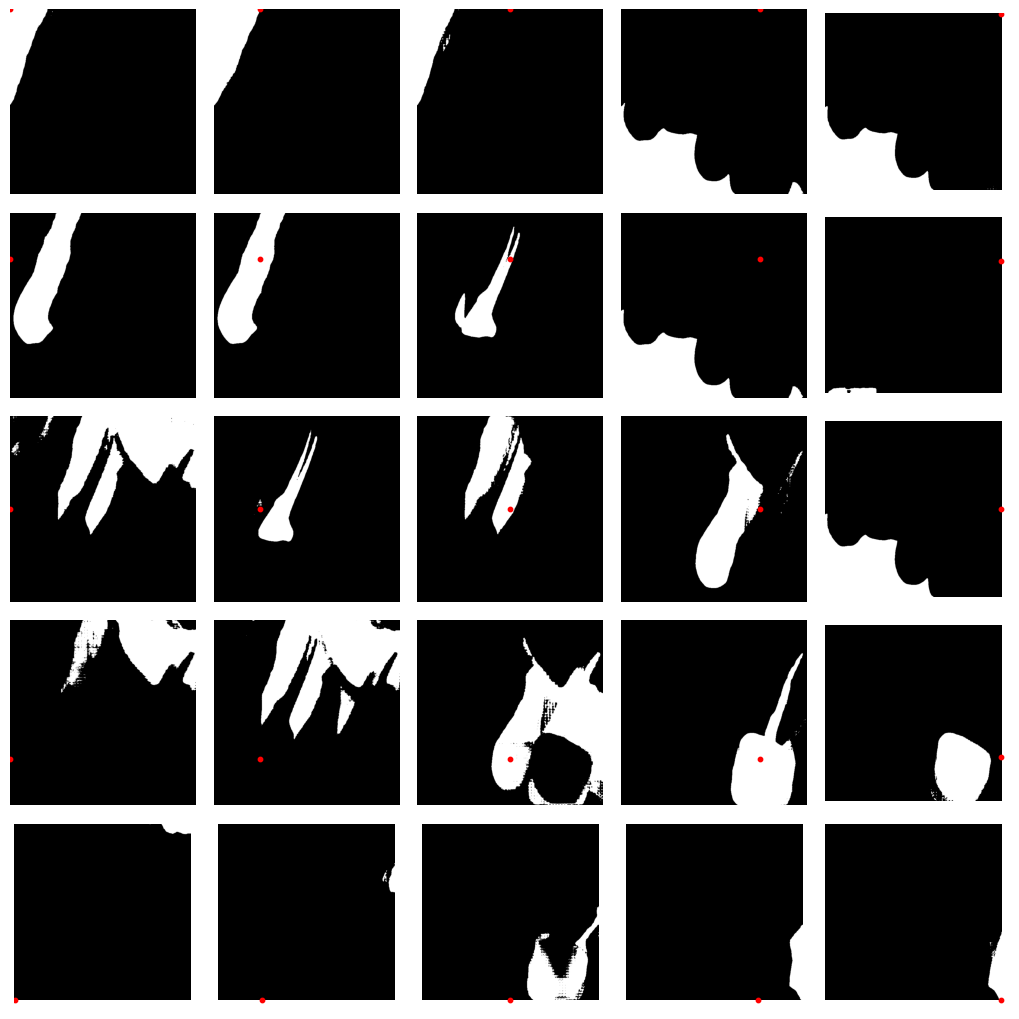

In [9]:
test_dataset.show_image_mask(image_idx)



fig, axes = plt.subplots(num_points+1, num_points+1, figsize=(10, 10))  # Adjust figure size
axes = axes.flatten()  # Flatten in case of 2D grid

for i, (mask, point) in enumerate(zip(masks, grid_points)):
    mask_array = mask[0]

    # Ensure mask is 2D
    if mask_array.ndim > 2:
        mask_array = mask_array[0, :, :]

    # Display the mask
    axes[i].imshow(mask_array, cmap='gray')
    axes[i].axis("off")  # Remove axis

    # Plot the grid point as a red dot
    y, x = point 
    axes[i].scatter(x, y, color='red', s=10)  # Red dot at grid point


# Remove gaps
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.1, hspace=0.1)
plt.show()

## Sam Base Model Evaluation

In [ ]:
evaluator = ModelEvaluator(mask_generator, processor, test_dataset)
results = evaluator.evaluate_mask_generator()
evaluator.print_results()

  0%|          | 0/82 [00:00<?, ?it/s]c:\Users\osmit\anaconda3\envs\pytorch-env\lib\site-packages\transformers\image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)
  1%|          | 1/82 [00:28<38:01, 28.17s/it]


KeyboardInterrupt: 

# Fine-Tuning SAM

### Set and verify dataloaders

In [ ]:
# Ensure images are returned as preprocessed tensors of the right size
test_dataset.return_as_sam  = True
train_dataset.return_as_sam = True
valid_dataset.return_as_sam = True

test_dataset.resize_mask  = True
train_dataset.resize_mask = True
valid_dataset.resize_mask = True

# Veryify item sizes
example = train_dataset[0]
for k,v in example.items():
  print(f"{k:<25} Shape: {str(v.shape):<30} Dtype: {v.dtype}")

pixel_values              Shape: torch.Size([3, 1024, 1024])    Dtype: torch.float32
original_sizes            Shape: torch.Size([2])                Dtype: torch.int64
reshaped_input_sizes      Shape: torch.Size([2])                Dtype: torch.int64
input_boxes               Shape: torch.Size([1, 4])             Dtype: torch.float64
ground_truth_mask         Shape: (256, 256)                     Dtype: float32


c:\Users\osmit\anaconda3\envs\pytorch-env\lib\site-packages\transformers\image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


In [ ]:
# Set up dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Verify batch item sizes
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(f"{k:<25} Shape: {str(v.shape):<30} Dtype: {v.dtype}")


pixel_values              Shape: torch.Size([2, 3, 1024, 1024]) Dtype: torch.float32
original_sizes            Shape: torch.Size([2, 2])             Dtype: torch.int64
reshaped_input_sizes      Shape: torch.Size([2, 2])             Dtype: torch.int64
input_boxes               Shape: torch.Size([2, 1, 4])          Dtype: torch.float64
ground_truth_mask         Shape: torch.Size([2, 256, 256])      Dtype: torch.float32


## Fine-Tuning Hugging Face SamProcessor

In [ ]:
# Initialize the processor
sam_model = SamModel.from_pretrained("facebook/sam-vit-large")

# make sure we only compute gradients for mask decoder
for name, param in sam_model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [ ]:


# Initialize the optimizer and the loss function
optimizer = Adam(sam_model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

# multi-class segmentation loss (Cross-Entropy + Dice Loss)
def multi_class_loss(predictions, targets):
    ce_loss = F.cross_entropy(predictions, targets)  # Cross-entropy
    dice_loss = DiceLoss(to_onehot_y=True, softmax=True)(predictions, targets)  # Dice loss
    return ce_loss + dice_loss


In [ ]:
from statistics import mean
from torch import nn
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 1

device = "cuda"
sam_model.to(device)

sam_model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):

      #print(batch.keys())
      
      #print(batch["pixel_values"].shape, batch["labels"].shape)


      # forward pass
      outputs = sam_model(pixel_values=batch["pixel_values"].to(device),
                      #input_masks=batch["labels"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)
      
      

      # calculate loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
     

# Save the model's state dictionary to a file
torch.save(sam_model.state_dict(), "Models/sam_vit_b_object_masks.pth")
     


## SAM Multi-Mask Output (NOT WORKING)

By default, SAM outputs binary masks. For multi-class segmentation and classification we need to:
 - Change the output layer of the decoder to have C channels, where C = number of classes in your dataset.
 - Use softmax activation instead of sigmoid, so each pixel gets assigned a class probability.

In [ ]:
import torch.nn as nn


# Load the SAM model
sam_checkpoint = "Models/sam_vit_l_0b3195.pth" 
sam_model = sam_model_registry["vit_l"](checkpoint=sam_checkpoint)
sam_model = sam_model.to("cuda")


# make sure we only compute gradients for mask decoder
for name, param in sam_model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)



# print(sam_model.mask_decoder)

### MULTICLASS OUTPUT

# Modify SAM's mask decoder output MLPs
for mlp in sam_model.mask_decoder.output_hypernetworks_mlps:
    mlp.layers[-1] = nn.Linear(in_features=256, out_features=8, bias=True)  # Adjust output to 8 classes

# Modify SAM’s upsampling layer to output 8 channels instead of 4
sam_model.mask_decoder.output_upscaling.add_module(
    "final_conv", nn.Conv2d(in_channels=32, out_channels=8, kernel_size=1)
)



# multi-class segmentation loss (Cross-Entropy & Dice Loss).
def multi_class_loss(predictions, targets):
    ce_loss = F.cross_entropy(predictions, targets)  # Cross-entropy
    dice_loss = DiceLoss(to_onehot_y=True, softmax=True)(predictions, targets)  # Dice loss
    return ce_loss + dice_loss

In [ ]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm

# DataLoaders (batch_size=1)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

# Optimizer & Scheduler
optimizer = optim.AdamW(sam_model.mask_decoder.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

# Move model to training mode
sam_model.train()

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0.0
    
    for batch in tqdm(train_dataloader):
        optimizer.zero_grad()

        # Load and move image & mask to GPU
        input_image = batch["pixel_values"].squeeze().to("cuda")  # [3, 1024, 1024]
        ground_truth_mask = batch["ground_truth_mask"].to("cuda").float() # [H, W] (Integer class labels)

        print(ground_truth_mask.shape)

        # Generate Image Embeddings
        with torch.no_grad():
            image_embedding = sam_model.image_encoder(input_image.unsqueeze(0)).to("cuda")  # [1, 256, 64, 64]

        # Generate Prompt Embeddings (using bounding box or None)
        with torch.no_grad():
            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                points=None, boxes=None, masks=ground_truth_mask
            )

        # Forward pass through mask decoder
        low_res_masks, iou_predictions = sam_model.mask_decoder(
            image_embeddings=image_embedding,
            image_pe=sam_model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False,
        )

        # Upscale masks to match original resolution
        upscaled_masks = sam_model.postprocess_masks(
            low_res_masks, input_size=(1024, 1024), original_image_size=(1024, 1024)
        ).to("cuda")  # Shape: [1, 8, 1024, 1024]

        # Compute loss
        loss = multi_class_loss(upscaled_masks, ground_truth_mask.unsqueeze(0))  # [1, 1024, 1024]

        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Adjust learning rate
    scheduler.step()

    # Print training progress
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Save fine-tuned model
torch.save(sam_model.state_dict(), "Models/sam_vit_l_finetuned.pth")
print("Training complete. Model saved.")

# Fine-Tuned Model Evaluation

### Load Model

In [79]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_model.load_state_dict(torch.load("Models/sam_vit_b_whole_masks.pth"))

# set the device to cuda
device = "cuda"
my_model.to(device)
     

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

### Test Inference

c:\Users\osmit\anaconda3\envs\pytorch-env\lib\site-packages\transformers\image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


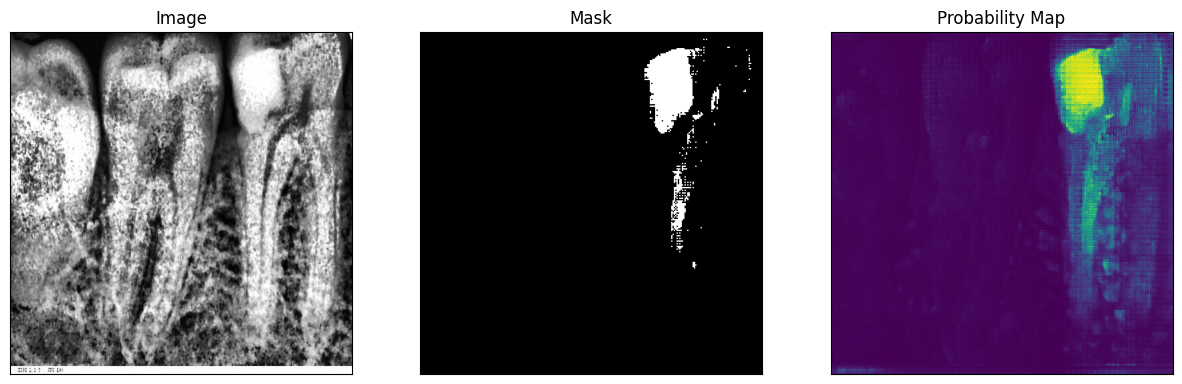

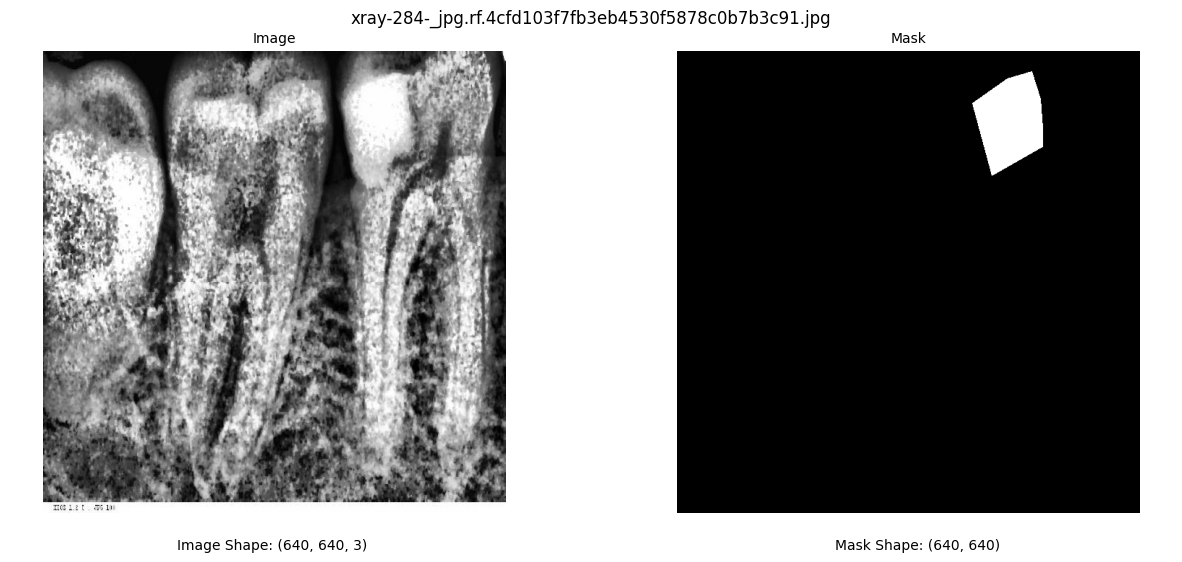

In [ ]:
test_dataset.return_as_sam = False
test_dataset.resize_mask      = True

# let's take a random training example
idx = random.randint(0, len(test_dataset)-1)

# load image
test_image = test_dataset[idx]["pixel_values"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(test_dataset[idx]["ground_truth_mask"])
prompt = test_dataset.get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")
inputs = {k: v.to("cuda") for k, v in inputs.items()}

my_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_model(**inputs, multimask_output=False)

# apply sigmoid
sam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

# convert soft mask to hard mask
sam_seg_prob = sam_seg_prob.cpu().numpy().squeeze()
sam_seg = (sam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(sam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(sam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

test_dataset.show_image_mask(idx)


#test_dataset.show_anns(idx, outputs["pred_masks"])

### Evaluate Perfomance

In [ ]:
evaluator = ModelEvaluator(my_model, processor, test_dataset)
results = evaluator.evaluate_sam_model()
evaluator.print_results()

  0%|          | 0/82 [00:00<?, ?it/s]c:\Users\osmit\anaconda3\envs\pytorch-env\lib\site-packages\transformers\image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)
100%|██████████| 82/82 [01:22<00:00,  1.00s/it]

IoU: 0.3314
Precision: 0.4300
Recall: 0.5406
F1 Score: 0.4488
Dice Score: 0.4488
MCC: 0.4488
